In [1]:
import pandas as pd
import tiktoken
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
DATA_PATH = '../../data/'
filename = 'english_cleaned_lyrics.csv'
zipfile = 'english_cleaned_lyrics.zip'


In [3]:
df = pd.read_csv(DATA_PATH + filename)
df

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...
...,...,...,...,...,...,...,...
218205,362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,I gotta say Boy after only just a couple of da...
218206,362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring You made me...
218207,362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth Looks a...
218208,362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth And I'm measu...


In [4]:
print('   -------------------')
print("Number of artists:", len(df['artist'].unique()))
print('   -------------------')
print("Genres:", df['genre'].unique())
print('   -------------------')
years = df['year'].unique()
years.sort()
print("years:", years)
print('   -------------------')

   -------------------
Number of artists: 10431
   -------------------
Genres: ['Pop' 'Hip-Hop' 'Rock' 'Metal' 'Other' 'Country' 'Jazz' 'Electronic'
 'Folk' 'R&B' 'Indie']
   -------------------
years: [  67  112  702 1968 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016]
   -------------------


In [5]:
df = df[~(df['genre'] == 'Other')]

In [6]:
df[(df['year'] == 67) | (df['year'] == 112) | (df['year'] == 702)]


,Unnamed: 0,index,song,year,artist,genre,lyrics
15554,27657,27657,star,702,clipse,Hip-Hop,You're my star It's such a wonder how you shin...
40894,69708,69708,anywhere-remix,112,dru-hill,Hip-Hop,Here we are all alone You and me privacy And w...
88365,147914,147914,it-s-over-now-remix,112,g-dep,Hip-Hop,What is this Numbers in your pocket I remember...
143439,238541,238541,come-see-me-remix,112,black-rob,Hip-Hop,Baby you can come see me cause I need you here...
190373,315540,315540,let-s-lurk,67,giggs,Hip-Hop,Verse 1 Still pulling up on smoke Skeng in my ...
201649,335205,335205,i-can-t-believe,112,faith-evans,Pop,I can't believe that love has gone away from ...


## Testing byte pair encoding with tiktoken on 1 sample

In [7]:
lyric = df['lyrics'][0]
preprocessed_lyric = lyric.lower()
preprocessed_lyric = ''.join(char for char in lyric if char not in string.punctuation)

stop_words = set(stopwords.words('english'))
filtered_lyric = [word for word in preprocessed_lyric.split() if word not in stop_words]
preprocessed_lyric = ' '.join(filtered_lyric)
print(f"lyrics before preprocessing {len(lyric)} words:", lyric)
print(f"lyrics after preprocessing {len(preprocessed_lyric)} words:", preprocessed_lyric)

lyrics before preprocessing 1913 words: Oh baby how you doing You know I'm gonna cut right to the chase Some women were made but me myself I like to think that I was created for a special purpose You know what's more special than you You feel me It's on baby let's get lost You don't need to call into work cause you're the boss For real want you to show me how you feel I consider myself lucky that's a big deal Why Well you got the key to my heart But you ain't gonna need it I'd rather you open up my body And show me secrets you didn't know was inside No need for me to lie It's too big it's too wide It's too strong it won't fit It's too much it's too tough He talk like this cause he can back it up He got a big ego such a huge ego I love his big ego it's too much He walk like this cause he can back it up Usually I'm humble right now I don't choose You can leave with me or you could have the blues Some call it arrogant I call it confident You decide when you find on what I'm working with D

In [8]:
def compare_encodings(example_string: str) -> None:
    """Prints a comparison of three string encodings."""
    # print the example string
    print(f'\nExample string: "{example_string}"')
    # for each encoding, print the # of tokens, the token integers, and the token bytes
    for encoding_name in ["r50k_base", "p50k_base", "cl100k_base", "gpt-4"]:
        if encoding_name == "gpt-4":
            encoding = tiktoken.encoding_for_model("gpt-4")
        else:
            encoding = tiktoken.get_encoding(encoding_name)

        token_integers = encoding.encode(example_string)
        num_tokens = len(token_integers)
        token_bytes = [encoding.decode_single_token_bytes(token) for token in token_integers]
        print()
        print(f"{encoding_name}: {num_tokens} tokens")
        print(f"token integers: {token_integers}")
        print(f"token bytes: {token_bytes}")

In [9]:
compare_encodings(lyric)


Example string: "Oh baby how you doing You know I'm gonna cut right to the chase Some women were made but me myself I like to think that I was created for a special purpose You know what's more special than you You feel me It's on baby let's get lost You don't need to call into work cause you're the boss For real want you to show me how you feel I consider myself lucky that's a big deal Why Well you got the key to my heart But you ain't gonna need it I'd rather you open up my body And show me secrets you didn't know was inside No need for me to lie It's too big it's too wide It's too strong it won't fit It's too much it's too tough He talk like this cause he can back it up He got a big ego such a huge ego I love his big ego it's too much He walk like this cause he can back it up Usually I'm humble right now I don't choose You can leave with me or you could have the blues Some call it arrogant I call it confident You decide when you find on what I'm working with Damn I know I'm killing

In [10]:
compare_encodings(df['lyrics'][2])


Example string: "If you search For tenderness It isn't hard to find You can have the love You need to live But if you look For truthfulness You might just As well be blind It always seems to be So hard to give Chorus Honesty Is such a lonely word Everyone is so untrue Honesty Is hardly ever heard And mostly What I need from you I can always Find someone To say They sympathize If I wear my heart Out on my sleeve But I don't want Some pretty face To tell me Pretty lies All I want Is someone To believe Chorus I can find a lover I can find a friend I can have security Until the bitter end Anyone can comfort me With promises again I know I know When I'm deep Inside of me Don't be Too concerned I won't ask For nothin' While I'm gone But when I want Sincerity Tell me where else Can I turn When You're the one That I depend upon Chorus "

r50k_base: 189 tokens
token integers: [1532, 345, 2989, 1114, 15403, 1108, 632, 2125, 470, 1327, 284, 1064, 921, 460, 423, 262, 1842, 921, 761, 284, 2107, 88

In [11]:
df[df['genre'] == 'Electronic']

,Unnamed: 0,index,song,year,artist,genre,lyrics
461,833,833,beautiful-people,2010,the-books,Electronic,Reverse Behold the finite set of thirteen con...
462,834,834,group-autogenics,2010,the-books,Electronic,Hello greetings and welcome Welcome to a new b...
463,836,836,chain-of-missing-links,2010,the-books,Electronic,At this extraordinary time in history where co...
464,838,838,the-story-of-hip-hop,2010,the-books,Electronic,Alright now shhhh I have the nicest surprise f...
465,839,839,a-cold-freezin-night,2010,the-books,Electronic,A cold freezin night Oh Baby Kill em I wish I ...
...,...,...,...,...,...,...,...
216469,359809,359809,special-feeling,2016,dizzy-dee,Electronic,Lionriddims Chorus It's that special feeling ...
218030,361993,361993,see-her-out,2016,francis-and-the-lights,Electronic,Just give me information Give me information t...
218031,361994,361994,my-city-s-gone,2016,francis-and-the-lights,Electronic,They boarded up my favorite bar A Frenchman l...
218032,361995,361995,thats-just-life,2016,francis-and-the-lights,Electronic,Just give me information Give me information t...


In [12]:
df = df[['artist', 'genre', 'year', 'lyrics', 'lyrics-preprocessed', 'byte-pair-encoding']]
df.to_csv(DATA_PATH + 'lyrics-preprocessed.csv', index=False)

KeyError: "['lyrics-preprocessed', 'byte-pair-encoding'] not in index"

<Axes: title={'center': 'Number of songs per genre'}, xlabel='genre'>

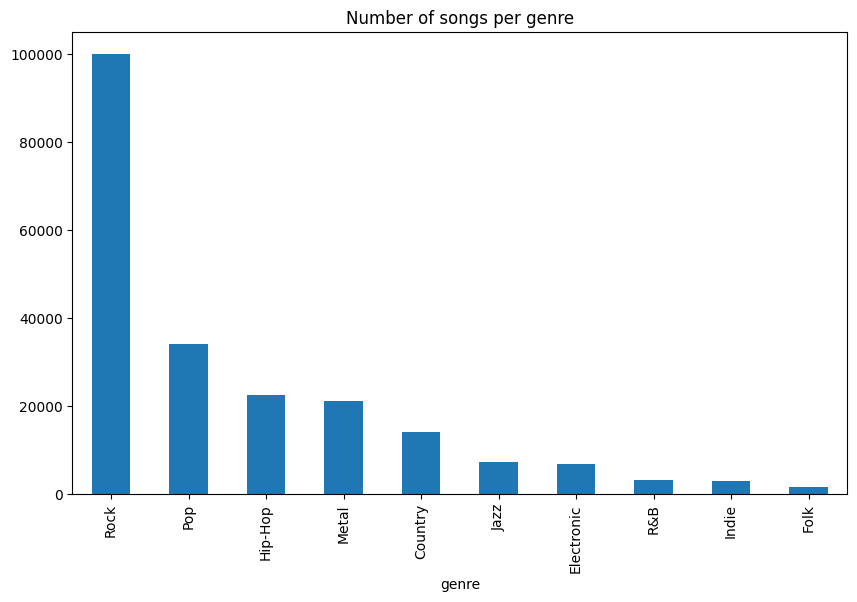

In [13]:
# plot histogram of music genres
df['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre')

In [ ]:
df[df['genre'] == 'Pop'].value_counts()

Unnamed: 0  index   song              year  artist           genre  lyrics                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [15]:
def map_genre_to_category(genre):
    if genre in ['Hip-Hop', 'R&B', 'Electronic']:
        return 'R&B/Hip-Hop/Electronic'
    elif genre in ['Country', 'Folk']:
        return 'Country/Folk'
    else:
        return genre

,Unnamed: 0,index,song,year,artist,genre,lyrics,genre_group
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...,Pop
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...,Pop
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...,Pop
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...,Pop
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...,Pop
...,...,...,...,...,...,...,...,...
218205,362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country/Folk,I gotta say Boy after only just a couple of da...,Country/Folk
218206,362233,362233,liar,2012,edens-edge,Country/Folk,I helped you find her diamond ring You made me...,Country/Folk
218207,362234,362234,last-supper,2012,edens-edge,Country/Folk,Look at the couple in the corner booth Looks a...,Country/Folk
218208,362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country/Folk,When I fly off this mortal earth And I'm measu...,Country/Folk


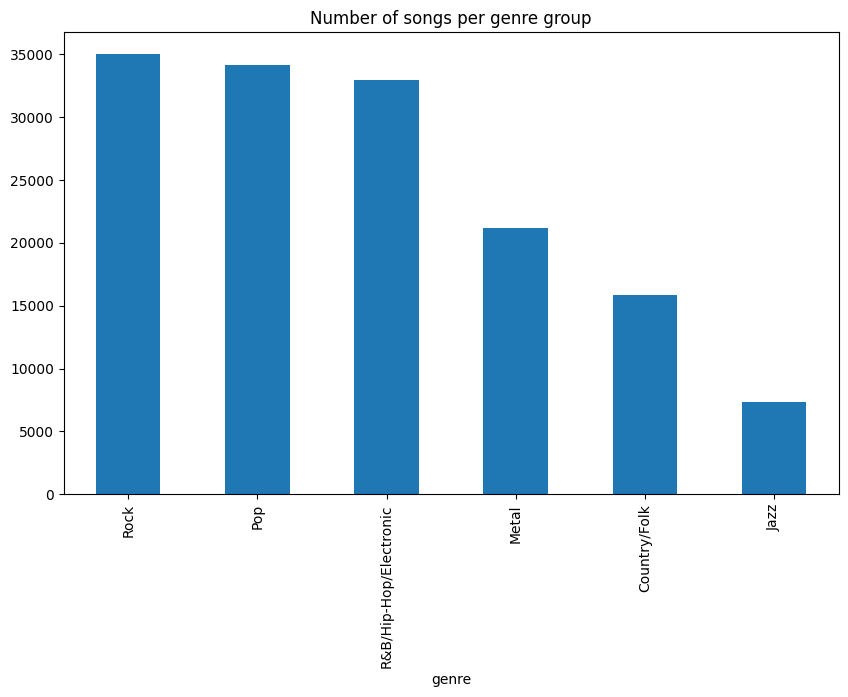

In [22]:
df['genre'] = df['genre'].apply(map_genre_to_category)
df['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre group')
display(df)

35000 35000


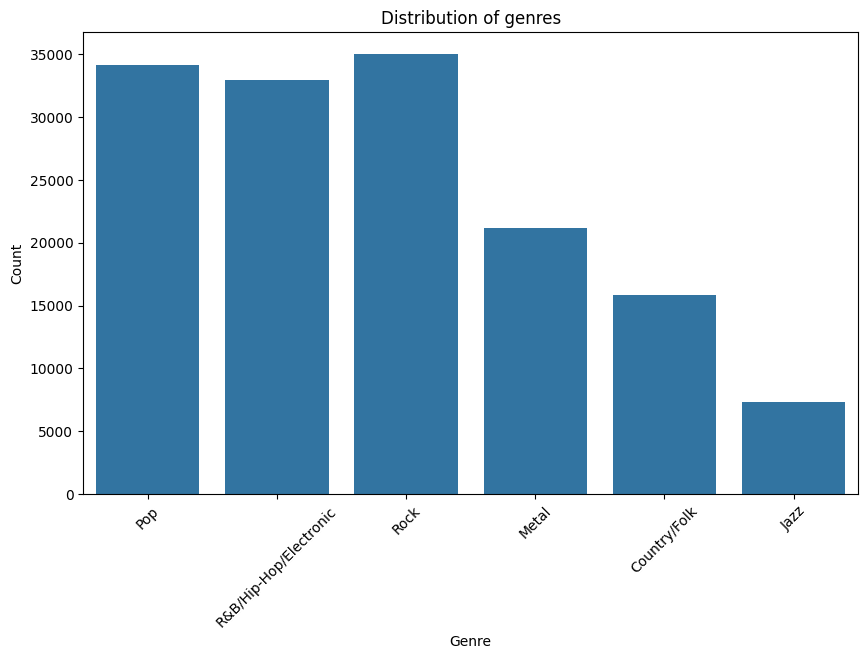

In [23]:
# Too many rocks songs, let's reduce the number of rock songs
df = df[~(df['genre'] == 'Other')]
df = df[~(df['genre'] == 'Indie')]

rocks_indices = df[df['genre'] == 'Rock'].index

num_rocks_to_keep = 35000
num_rocks_current = len(rocks_indices)

print(num_rocks_current, num_rocks_to_keep)

if num_rocks_current > num_rocks_to_keep:
    keep_indices = np.random.choice(rocks_indices, num_rocks_to_keep, replace=False)
else:
    keep_indices = rocks_indices

df = df.drop(index=set(rocks_indices) - set(keep_indices))

plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()